# SAE latent vector difference based negative sampling

In the FIRE notebook, I tested to see whether we could take the difference between latent vectors from a SAE initially trained on ProtBERT-encoded swissprot proteins and refined on our small samples could yield truly be diffrent proteins for negative sampling. 

This experiment was performed by taking protein pairs that had a FIRE score and taking the difference of their latent vectors. The below chart visualize the results and confirmed the hypothesis. Thus, we'll be using a SAE to take the difference between latent vectors and sample based on protein magnitude. 

In [1]:
import sys
sys.path.append("..")

from transformers import AutoTokenizer, AutoModel
import pandas as pd

from Utils.negative_sampling import magnitude

In [2]:
df = pd.read_csv("../Data/TrainingData/PositiveSamples/RNAInter_small_interactions_current.csv", index_col = 0)
df

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas
907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGC...
911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTG...
912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAA...
912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...
2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923224,RP33979079,rno-miR-374-5p,MIMAT0003208,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,AUAUAAUACAACCUGCUAAGUG
8923231,RP33979091,hsa-miR-203b-5p,MIMAT0019813,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAE...,P03129,UAGUGGUCCUAAACAUUUCACA
8923232,RP33979092,hsa-miR-203b-3p,MIMAT0019814,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAE...,P03129,UUGAACUGUUAAGAACCACUGGA
8923245,RP33979111,hiv1-miR-TAR-5p,MIMAT0006016,miRNA,Human immunodeficiency virus 1,tat,155871.0,protein,Human immunodeficiency virus 1,0.9975,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...,P04608,UCUCUCUGGUUAGACCAGAUCUGA


In [3]:
prot_df = df[["Protein_name","NCBI_GeneID","Protein_Type","Also_species","proteins"]].drop_duplicates()

prot_df 

,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins
907814,HMGN3,9324.0,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...
2122927,SUMO2,6613.0,TF,Homo sapiens,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
2361785,ZNF706,51123.0,protein,Homo sapiens,MARGQQKIQSQQKNAKKQAGQKKKQGHDQKAAAKAALIYTCTVCRT...
3098305,Dpy30,66310.0,TF,Mus musculus,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...
5902894,CXCL8,3576.0,protein,Homo sapiens,MTSKLAVALLAAFLISAALCEGAVLPRSAKELRCQCIKTYSKPFHP...
...,...,...,...,...,...
8912647,Prm1,19118.0,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTI...
8917893,Sumo1,22218.0,TF,Mus musculus,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
8917895,Sumo2,170930.0,TF,Mus musculus,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
8923194,E7,1489079.0,protein,Human papillomavirus type 16,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAE...


In [4]:
from math import factorial

factorial(349)/(factorial(349-2)*factorial(2))

60726.0

In [5]:
from itertools import combinations

protein_combo_df = pd.concat([pd.concat([left, right]) for (_,left), (_,right) in combinations(prot_df.iterrows(), r = 2)],
                              axis = 1).T

len(protein_combo_df) == factorial(349)/(factorial(349-2)*factorial(2))

True

In [6]:
identical_species = (protein_combo_df['Also_species'].iloc[:,0]) == (protein_combo_df['Also_species'].iloc[:,1])

In [7]:
protein_combo_df

,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins
0,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,SUMO2,6613,TF,Homo sapiens,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
1,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,ZNF706,51123,protein,Homo sapiens,MARGQQKIQSQQKNAKKQAGQKKKQGHDQKAAAKAALIYTCTVCRT...
2,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,Dpy30,66310,TF,Mus musculus,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...
3,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,CXCL8,3576,protein,Homo sapiens,MTSKLAVALLAAFLISAALCEGAVLPRSAKELRCQCIKTYSKPFHP...
4,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,HMGA1,3159,TF,Homo sapiens,MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQK...
...,...,...,...,...,...,...,...,...,...,...
60721,Sumo1,22218,TF,Mus musculus,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...,E7,1.48908e+06,protein,Human papillomavirus type 16,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAE...
60722,Sumo1,22218,TF,Mus musculus,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...,tat,155871,protein,Human immunodeficiency virus 1,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...
60723,Sumo2,170930,TF,Mus musculus,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,E7,1.48908e+06,protein,Human papillomavirus type 16,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAE...
60724,Sumo2,170930,TF,Mus musculus,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...,tat,155871,protein,Human immunodeficiency virus 1,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGIS...


In [8]:
display(protein_combo_df['Also_species'].iloc[:,0].value_counts())
print('---')
protein_combo_df['Also_species'].iloc[:,1].value_counts()

Homo sapiens                    57309
Mus musculus                     3409
Drosophila melanogaster             7
Human papillomavirus type 16        1
Name: Also_species, dtype: int64

---


Homo sapiens                      39087
Mus musculus                      20603
Human immunodeficiency virus 1      348
Human papillomavirus type 16        347
Drosophila melanogaster             341
Name: Also_species, dtype: int64

In [9]:
# remove entries that contain different 
protein_combo_df_identical_species = protein_combo_df[identical_species]
protein_combo_df_identical_species

,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins
0,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,SUMO2,6613,TF,Homo sapiens,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
1,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,ZNF706,51123,protein,Homo sapiens,MARGQQKIQSQQKNAKKQAGQKKKQGHDQKAAAKAALIYTCTVCRT...
3,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,CXCL8,3576,protein,Homo sapiens,MTSKLAVALLAAFLISAALCEGAVLPRSAKELRCQCIKTYSKPFHP...
4,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,HMGA1,3159,TF,Homo sapiens,MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQK...
5,HMGN3,9324,TF,Homo sapiens,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKT...,HMGA2,8091,protein,Homo sapiens,MSARGEGAGQPSTSAQGQPAAPAPQKRGRGRPRKQQQEPTGEPSPK...
...,...,...,...,...,...,...,...,...,...,...
60712,Hmga2,15364,TF,Mus musculus,MSARGEGAGQPSTSAQGQPAAPVPQKRGRGRPRKQQQEPTCEPSPK...,Sumo1,22218,TF,Mus musculus,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
60713,Hmga2,15364,TF,Mus musculus,MSARGEGAGQPSTSAQGQPAAPVPQKRGRGRPRKQQQEPTCEPSPK...,Sumo2,170930,TF,Mus musculus,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...
60716,Prm1,19118,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTI...,Sumo1,22218,TF,Mus musculus,MSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHLKK...
60717,Prm1,19118,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTI...,Sumo2,170930,TF,Mus musculus,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKA...


In [10]:
protein_combo_df_identical_species['Also_species'].iloc[:,0].value_counts()

Homo sapiens    38226
Mus musculus     2346
Name: Also_species, dtype: int64

In [11]:
identical_seq1 = protein_combo_df_identical_species['proteins'].iloc[:,0]
identical_seq2 = protein_combo_df_identical_species['proteins'].iloc[:,1]

seq1 = protein_combo_df['proteins'].iloc[:,0]
seq2 = protein_combo_df['proteins'].iloc[:,1]

In [12]:
processed_identical_seq1 = list(identical_seq1.str.join(' '))
processed_identical_seq2 = list(identical_seq2.str.join(' '))

processed_seq1 = list(seq1.str.join(' '))
processed_seq2 = list(seq2.str.join(' '))

In [15]:
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

In [16]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

In [17]:
import torch

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [18]:
from torch.utils.data import IterableDataset

class TestData(IterableDataset):
    """
    
    """
    def __init__(self, proteins, tokenizer, model, chunksize, cuda = True):
        self.protein_combos  = proteins
        self.tokenizer       = tokenizer
        self.model           = model
        self.chunksize       = chunksize
        
        self.cuda = cuda
        
        if self.cuda:
            self.model.to('cuda');
        
    def __iter__(self):
        # swap below as a protein comboooooooo
        
        for i in tqdm(range(0,len(self.protein_combos),self.chunksize)):
            
            #print(list(self.protein_combos[i:i+self.chunksize]))
            
            tokenized_protein = self.tokenizer(list(self.protein_combos[i:i+self.chunksize]),
                                               padding = 'max_length',
                                               max_length = 112,
                                               return_tensors='pt')
            
            if self.cuda:
                tokenized_protein.to('cuda');
            
            yield mean_pooling(self.model(**tokenized_protein), tokenized_protein['attention_mask']).detach()

In [19]:
CHUNKSIZE = 2
identical_x_data = TestData(processed_identical_seq1, tokenizer, model, CHUNKSIZE, cuda = True)
identical_y_data = TestData(processed_identical_seq2, tokenizer, model, CHUNKSIZE, cuda = True)

x_data = TestData(processed_seq1, tokenizer, model, CHUNKSIZE, cuda = True)
y_data = TestData(processed_seq2, tokenizer, model, CHUNKSIZE, cuda = True)

In [14]:
import torch
from tqdm.notebook import tqdm
import os

sae_negative_sample_same_species_x_pth = "sae_negative_identical_species_sample_x.pt"

if not os.path.exists(sae_negative_sample_same_species_x_pth):
    identical_x_tensor = torch.stack([i for i in identical_x_data])
    SHAPE              = len(processed_identical_seq1)
    identical_x_tensor_reshaped = identical_x_tensor.reshape(SHAPE, 1024)
    torch.save(identical_x_tensor_reshaped, sae_negative_sample_same_species_x_pth)
else:
    x_identical_tensor_reshaped = torch.load(sae_negative_sample_same_species_x_pth)

In [20]:
sae_negative_sample_same_species_y_pth = "sae_negative_identical_species_sample_y.pt"

if not os.path.exists(sae_negative_sample_same_species_y_pth):
    y_tensor          = torch.stack([i for i in identical_y_data])
    SHAPE             = len(processed_identical_seq2)
    y_tensor_reshaped = y_tensor.reshape(SHAPE, 1024)
    torch.save(y_tensor_reshaped, sae_negative_sample_same_species_y_pth)
else:
    y_identical_tensor_reshaped = torch.load(sae_negative_sample_same_species_y_pth)

In [21]:
sae_negative_sample_x_pth = "sae_negative_sample_x.pt"

if not os.path.exists(sae_negative_sample_x_pth):
    x_tensor          = torch.stack([i for i in x_data])
    SHAPE             = len(processed_seq1)
    x_tensor_reshaped = x_tensor.reshape(SHAPE, 1024)
    torch.save(x_tensor_reshaped, sae_negative_sample_x_pth)
else:
    x_tensor_reshaped = torch.load(sae_negative_sample_x_pth)

In [22]:
sae_negative_sample_y_pth = "sae_negative_sample_y.pt"

if not os.path.exists(sae_negative_sample_y_pth):
    y_tensor          = torch.stack([i for i in y_data])
    SHAPE             = len(processed_seq2)
    y_tensor_reshaped = y_tensor.reshape(SHAPE, 1024)
    torch.save(y_tensor_reshaped, sae_negative_sample_y_pth)
else:
    y_tensor_reshaped = torch.load(sae_negative_sample_y_pth)

In [23]:
import sys
sys.path.append("/home/robertlink/Thesis_work")

#unrefined_sae = torch.load("../Data/BERT_Swiss_unrefined_SAE.pt")
refined_sae   = torch.load("../Data/EncodedData/BERT_Swiss_refined_SAE.pt")

In [24]:
refined_sae.train_step = 0
refined_sae.eval();

refined_diff_matrix   = refined_sae(x_tensor_reshaped) - refined_sae(y_tensor_reshaped)

In [26]:
diff_magnitudes = magnitude( refined_diff_matrix ).cpu().numpy()

In [27]:
refined_diff_matrix.cpu().numpy()

array([[-1.5455753e-02,  3.1998381e-03, -2.6794708e-01, ...,
         1.8236586e-01, -1.3178486e+00,  2.8466843e-03],
       [-7.4714071e-01,  3.5477104e-03, -1.1959405e+00, ...,
         5.3964978e-01, -1.3572618e+00,  4.9849334e-03],
       [-1.5395159e-02,  4.1122995e-03,  2.1913788e-01, ...,
        -3.2333469e-01, -3.6801833e-01,  3.7716310e-03],
       ...,
       [ 1.3643298e-03, -4.7709191e-01,  5.0324237e-01, ...,
        -6.9111317e-02,  1.3209244e+00,  7.2919494e-03],
       [-3.3855406e-03, -8.8764392e-03,  4.8571143e-01, ...,
         3.5612118e-01,  5.7719994e-01,  6.9917645e-03],
       [-4.7498704e-03,  4.6821547e-01, -1.7530914e-02, ...,
         4.2523250e-01, -7.4372447e-01, -3.0018482e-04]], dtype=float32)

In [28]:
# calculate vector magnitudes
protein_combo_df['difference_magnitudes'] = diff_magnitudes

# sort by descending magnitude
protein_combo_df = protein_combo_df.sort_values(by=['difference_magnitudes'], ascending=False)

protein_combo_df

,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins,difference_magnitudes
19883,RPL41,6171,protein,Homo sapiens,MRAKWRKKRMRRLKRKRRKMRQRSK,KRTAP19-1,337882,protein,Homo sapiens,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,24.882833
19884,RPL41,6171,protein,Homo sapiens,MRAKWRKKRMRRLKRKRRKMRQRSK,KRTAP6-1,337966,protein,Homo sapiens,MCGSYYGNYYGTPGYGFCGYGGLGYGYGGLGCGYGSCCGCGFRRLGCGYGYGSRSLCGYGYGCGSGSGYYY,24.500219
58510,Lyrm7,75530,protein,Mus musculus,MGQPAKVLQLFKTLHRTRQQVFKNDKRALEAARVKINEEFKKHKNETSPEKIKEMMKLGSDVELLLRTAVIQGIHTDHDTLQLVPRKDLLTENVPYCDAPTQKQ,Prm1,19118,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.297199
23865,LYRM7,90624,protein,Homo sapiens,MGRAVKVLQLFKTLHRTRQQVFKNDARALEAARIKINEEFKNNKSETSSKKIEELMKIGSDVELLLRTSVIQGIHTDHNTLKLVPRKDLLVENVPYCDAPTQKQ,Prm1,19118,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.221001
13750,SRP9,6726,protein,Homo sapiens,MPQYQTWEEFSRAAEKLYLADPMKARVVLKYRHSDGNLCVKVTDDLVCLVYKTDQAQDVKKIEKFHSQLMRLMVAKEARNVTMETE,Prm1,19118,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.099562
...,...,...,...,...,...,...,...,...,...,...,...
13020,HIST2H4B,554313,protein,Homo sapiens,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG,HIST1H4D,8360,protein,Homo sapiens,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG,0.000000
57274,GNG2,54331,protein,Homo sapiens,MASNNTASIAQARKLVEQLKMEANIDRIKVSKAAADLMAYCEAHAKEDPLLTPVPASENPFREKKFFCAIL,Gng2,14702,protein,Mus musculus,MASNNTASIAQARKLVEQLKMEANIDRIKVSKAAADLMAYCEAHAKEDPLLTPVPASENPFREKKFFCAIL,0.000000
35713,DYNLL1,8655,protein,Homo sapiens,MCDRKAVIKNADMSEEMQQDSVECATQALEKYNIEKDIAAHIKKEFDKKYNPTWHCIVGRNFGSYVTHETKHFIYFYLGQVAILLFKSG,Dynll1,56455,protein,Mus musculus,MCDRKAVIKNADMSEEMQQDSVECATQALEKYNIEKDIAAHIKKEFDKKYNPTWHCIVGRNFGSYVTHETKHFIYFYLGQVAILLFKSG,0.000000
23521,HIST2H4A,8370,protein,Homo sapiens,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG,HIST1H4C,8364,protein,Homo sapiens,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG,0.000000


In [29]:
SAVE = True
pair_latent_diff_df_path = '../Data/latent_protein_pair_differences.csv'

if SAVE:
    protein_combo_df.to_csv(pair_latent_diff_df_path, index = False)

In [29]:
protein_combo_df['NCBI_GeneID']

,NCBI_GeneID,NCBI_GeneID
19883,6171,337882
19884,6171,337966
58510,75530,19118
23865,90624,19118
13750,6726,19118
...,...,...
13020,554313,8360
57274,54331,14702
35713,8655,56455
23521,8370,8364


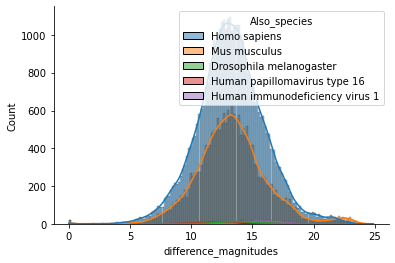

In [30]:
import seaborn as sbn 

sbn.histplot(data = protein_combo_df,
             x = 'difference_magnitudes',
             hue = protein_combo_df['Also_species'].iloc[:,1],
             #bins = 100,
             kde = True)

sbn.despine()

In [29]:
from cuml.cluster import DBSCAN

In [30]:
dbscan   = DBSCAN(eps=1.0, min_samples=3)
clusters = dbscan.fit_predict(refined_diff_matrix.cpu().numpy())

In [31]:
pd.Series(clusters).value_counts()

-1      57911
 2         45
 19        15
 260       12
 347       12
        ...  
 585        3
 553        3
 153        3
 313        3
 575        3
Length: 589, dtype: int64

In [39]:
refined_diff_matrix

tensor([[-1.5456e-02,  3.1998e-03, -2.6795e-01,  ...,  1.8237e-01,
         -1.3178e+00,  2.8467e-03],
        [-7.4714e-01,  3.5477e-03, -1.1959e+00,  ...,  5.3965e-01,
         -1.3573e+00,  4.9849e-03],
        [-1.5395e-02,  4.1123e-03,  2.1914e-01,  ..., -3.2333e-01,
         -3.6802e-01,  3.7716e-03],
        ...,
        [ 1.3643e-03, -4.7709e-01,  5.0324e-01,  ..., -6.9111e-02,
          1.3209e+00,  7.2919e-03],
        [-3.3855e-03, -8.8764e-03,  4.8571e-01,  ...,  3.5612e-01,
          5.7720e-01,  6.9918e-03],
        [-4.7499e-03,  4.6822e-01, -1.7531e-02,  ...,  4.2523e-01,
         -7.4372e-01, -3.0018e-04]], device='cuda:0')

In [31]:
class FIRE():
    """
    COPIED FROM 
    """
    
    def __init__(self, similarity_table,
                 protein_info_cols,
                 seed,
                 max_samples_per_pair = None):
        
        # FIRE output parameters
        self.similarity_table     = similarity_table
        self.prot_info_cols       = protein_info_cols
        self.seed                 = seed
        self.max_samples_per_pair = max_samples_per_pair
        
    def isolate_rna_prot_interactions(self, positive_df, uniprot_id):
        return positive_df[(positive_df['UniprotID'] == uniprot_id)]
    
    def isolate_protein_seq_and_info(self, uniprot_block):
        return uniprot_block[self.prot_info_cols].iloc[0].values
    
    def create_negative_sample_df(self, uniprot_block1, uniprot_block2):
        return pd.concat([uniprot_block1.iloc[:self.max_samples_per_pair,:], 
                          uniprot_block2.iloc[:self.max_samples_per_pair,:]], axis = 0)
        
    def create_negative_samples(self, uniprot_id1, uniprot_id2, positive_df):
        """
        X
        """
        
        uniprot1_block = self.isolate_rna_prot_interactions(positive_df, uniprot_id1)
        uniprot2_block = self.isolate_rna_prot_interactions(positive_df, uniprot_id2)
        
        # Isolate protein seqs
        uniprot_seq_and_info1 = self.isolate_protein_seq_and_info(uniprot1_block)
        uniprot_seq_and_info2 = self.isolate_protein_seq_and_info(uniprot2_block)

        # Swap protein info
        uniprot1_block.loc[:,self.prot_info_cols] = uniprot_seq_and_info2
        uniprot2_block.loc[:,self.prot_info_cols] = uniprot_seq_and_info1

        # Combine blocks
        negative_sample_frame = self.create_negative_sample_df(uniprot1_block, uniprot2_block)
        
        return negative_sample_frame
    
    def _auto_calculate_max_samples(self, positive_df):
        number_unique_uniprot_ids = len(set(pd.concat((self.similarity_table['uniprot1'], self.similarity_table['uniprot2']))))
        self.negative_samples     = len(positive_df) / number_unique_uniprot_ids
    
    def _trim_extra_negative_samples(self, negative_df, diff):
        
        extra      = negative_df.sample(diff, random_state = self.seed)
        trimmed_df = negative_df.drop(extra.index)
        
        return trimmed_df
    
    def generate_negative_samples(self, positive_df):
        """
        
        """
        
        negative_df = pd.DataFrame()
        samples = 0
        
        if not self.max_samples_per_pair:
            self._auto_calculate_max_samples(positive_df)
        
        for _, uniprot_id1, uniprot_id2 in self.similarity_table[['uniprot1','uniprot2']].itertuples():
            
            if samples >= len(positive_df):
                break
            
            negative_samples = self.create_negative_samples(uniprot_id1, uniprot_id2, positive_df)
            
            negative_df = pd.concat((negative_df, negative_samples), axis = 0)
            
            samples += len(negative_samples)
        
        
        negative_df.index = pd.RangeIndex(len(negative_df))
        
        ################################################################
        # If there is a greater number of negative samples than positive 
        # samples randomly trim any exra samples  
        ################################################################
        sample_diff = max([len(negative_df) - len(positive_df), 0])
        if sample_diff:
            negative_df = self._trim_extra_negative_samples(negative_df, sample_diff)
            negative_df.index = pd.RangeIndex(len(negative_df))
            
        negative_df['interacts'] = 0
            
        return negative_df

In [32]:
class LatentVectorDifferenceSampler(FIRE):
    """
    TODO:
    > match negative sample species distribution to positive sample
    > incorperate 
    """
    
    def __init__(self, similarity_table, protein_info_cols, seed, max_samples_per_pair = None):
        super().__init__(similarity_table, protein_info_cols, seed, max_samples_per_pair)
        
    def isolate_rna_prot_interactions(self, positive_df, gene_id):
        return positive_df[(positive_df['NCBI_GeneID'] == gene_id)]    
    
    def _auto_calculate_max_samples(self, positive_df):
        number_unique_uniprot_ids = len(set(pd.concat((self.similarity_table['NCBI_GeneID'].iloc[:,0], 
                                                       self.similarity_table['NCBI_GeneID'].iloc[:,1]))))
        self.negative_samples     = len(positive_df) / number_unique_uniprot_ids
    
    def generate_negative_samples(self, positive_df):
        """
        
        """
        
        negative_df = pd.DataFrame()
        samples = 0
        
        if not self.max_samples_per_pair:
            self._auto_calculate_max_samples(positive_df)
        
        for _, gene_id1, gene_id2 in self.similarity_table['NCBI_GeneID'].itertuples():
            
            if samples >= len(positive_df):
                break
            
            negative_samples = self.create_negative_samples(gene_id1, gene_id2, positive_df)
            
            negative_df = pd.concat((negative_df, negative_samples), axis = 0)
            
            samples += len(negative_samples)
        
        
        negative_df.index = pd.RangeIndex(len(negative_df))
        
        ################################################################
        # If there is a greater number of negative samples than positive 
        # samples randomly trim any exra samples  
        ################################################################
        sample_diff = max([len(negative_df) - len(positive_df), 0])
        if sample_diff:
            negative_df = self._trim_extra_negative_samples(negative_df, sample_diff)
            negative_df.index = pd.RangeIndex(len(negative_df))
            
        negative_df['interacts'] = 0
            
        return negative_df    
        

# PROTEIN_INFO_COLS = ['Protein_name','NCBI_GeneID','Protein_Type','Also_species','proteins','UniprotID']

# fire = FIRE(similarity_frame,
#             protein_info_cols    = PROTEIN_INFO_COLS,
#             seed                 = 255,
#             max_samples_per_pair = None)

# negative_samples = fire.generate_negative_samples(df)

In [33]:
PROTEIN_INFO_COLS = ['Protein_name','NCBI_GeneID','Protein_Type','Also_species','proteins','UniprotID']

sampler = LatentVectorDifferenceSampler(protein_combo_df,
                                        protein_info_cols    = PROTEIN_INFO_COLS,
                                        seed                 = 255,
                                        max_samples_per_pair = None)

negative_samples = sampler.generate_negative_samples(df)

/home/robertlink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/robertlink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
/home/robertlink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1760: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [34]:
negative_samples

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,RP07544391,hsa-miR-410-5p,MIMAT0026558,miRNA,Homo sapiens,KRTAP19-1,337882.0,protein,Homo sapiens,0.5117,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,Q8IUB9,AGGUUGUCUGUGAUGAGUUCG,0
1,RP07544392,hsa-miR-494-5p,MIMAT0026607,miRNA,Homo sapiens,KRTAP19-1,337882.0,protein,Homo sapiens,0.5117,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,Q8IUB9,AGGUUGUCCGUGUUGUCUUCUCU,0
2,RP07544393,hsa-miR-584-5p,MIMAT0003249,miRNA,Homo sapiens,KRTAP19-1,337882.0,protein,Homo sapiens,0.5117,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,Q8IUB9,UUAUGGUUUGCCUGGGACUGAG,0
3,RP07544394,hsa-miR-758-5p,MIMAT0022929,miRNA,Homo sapiens,KRTAP19-1,337882.0,protein,Homo sapiens,0.5117,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,Q8IUB9,GAUGGUUGACCAGAGAGCACAC,0
4,RP07544395,hsa-miR-323b-5p,MIMAT0001630,miRNA,Homo sapiens,KRTAP19-1,337882.0,protein,Homo sapiens,0.5117,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,Q8IUB9,AGGUUGUCCGUGGUGAGUUCGCA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12156,RP07845795,hsa-miR-655-3p,MIMAT0003331,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AUAAUACAUGGUUAACCUCUUU,0
12157,RP07845796,hsa-miR-374c-5p,MIMAT0018443,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AUAAUACAACCUGCUAAGUGCU,0
12158,RP07845797,hsa-miR-3680-5p,MIMAT0018106,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,GACUCACUCACAGGAUUGUGCA,0
12159,RP07845798,hsa-miR-376c-3p,MIMAT0000720,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AACAUAGAGGAAAUUCCACGU,0


In [35]:
df['interacts'] = 1
df.head()

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA,1
911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT,1
912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA,1
912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1


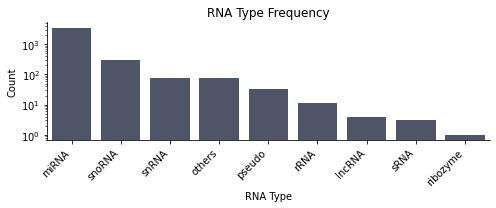

In [36]:
###########################################
# Unique RNA and Protein Types
###########################################

import matplotlib.pyplot as plt
import seaborn as sbn

fig, ax = plt.subplots(1,1, figsize = (7,3))

# Create dataframes containing all unique RNAs/Proteins and their types
unique_rna_df     = negative_samples.groupby(['RNA_Name','RNA_type']).size().reset_index()
unique_protein_df = negative_samples.groupby(['Protein_name','Protein_Type']).size().reset_index()

###

PALETTE = sbn.color_palette("Purples_r", 9)
COLOR   = '#4a536b'

sbn.countplot(x = 'RNA_type', 
              data = unique_rna_df,
              #palette = PALETTE,
              color = COLOR,
              order = unique_rna_df.RNA_type.value_counts().index,
              ax = ax)

ax.set_title("RNA Type Frequency")
ax.set_yscale('log')
ax.set_xlabel('RNA Type')
ax.set_ylabel('Count')

plt.xticks(rotation = 45, ha = 'right')

sbn.despine()

plt.tight_layout()
#plt.savefig("RNA_types_0.5_confidence.png", dpi = 300, transparent=True)

In [37]:
negative_samples['Also_species'].value_counts()

Mus musculus                    7189
Homo sapiens                    4876
Drosophila melanogaster           95
Human papillomavirus type 16       1
Name: Also_species, dtype: int64

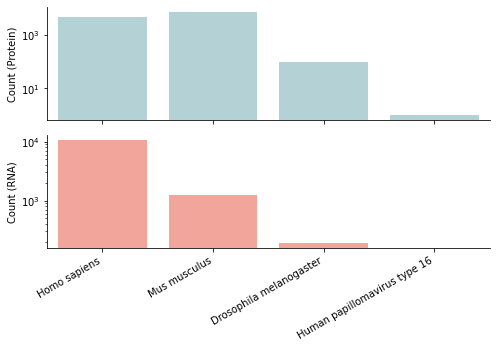

In [38]:
most_common_species = pd.concat((negative_samples['Species'], negative_samples['Also_species'])).value_counts().index


fig, axes = plt.subplots(2,1, figsize = (7,5), sharex = True)

most_common_species_df = negative_samples[negative_samples['Also_species'].isin(most_common_species) & negative_samples['Species'].isin(most_common_species)]

COLOR1 = '#aed6dc'
COLOR2 = '#ff9a8d'

sbn.countplot(x = "Also_species", 
              data = most_common_species_df,
              color = COLOR1,
              order = most_common_species,
              ax = axes[0])

axes[0].set_xlabel('')
axes[0].set_yscale('log')
axes[0].set_ylabel('Count (Protein)')

sbn.countplot(x = "Species",
              data = most_common_species_df,
              color = COLOR2,
              order = most_common_species,
              ax = axes[1])

axes[1].set_yscale('log')
axes[1].set_xlabel('')
axes[1].set_ylabel('Count (RNA)')

plt.xticks(rotation=30, ha = 'right')

sbn.despine()

plt.tight_layout()

In [39]:
training_data = pd.concat((df, negative_samples))
training_data.index = pd.RangeIndex(len(training_data))
training_data

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas,interacts
0,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA,1
1,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT,1
2,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA,1
3,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
4,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24317,RP07845795,hsa-miR-655-3p,MIMAT0003331,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AUAAUACAUGGUUAACCUCUUU,0
24318,RP07845796,hsa-miR-374c-5p,MIMAT0018443,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AUAAUACAACCUGCUAAGUGCU,0
24319,RP07845797,hsa-miR-3680-5p,MIMAT0018106,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,GACUCACUCACAGGAUUGUGCA,0
24320,RP07845798,hsa-miR-376c-3p,MIMAT0000720,miRNA,Homo sapiens,Prm1,19118.0,TF,Mus musculus,0.5117,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,P02319,AACAUAGAGGAAAUUCCACGU,0


In [40]:
SAVEDATA = True

if SAVEDATA:
    # ignore index_col
    training_data.to_csv("../Data/TrainingData/RNAInter_small_interaction_sae_difference_training_data_current.csv", index = False)

# Same deal for unrefined SAE

In [41]:
import sys
sys.path.append("/home/robertlink/Thesis_work")

unrefined_sae = torch.load("../Data/BERT_Swiss_unrefined_SAE.pt")